In [251]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from sklearn import metrics



In [12]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [27]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

In [28]:
data.head()

,filename,category,class
0,N_BA_100102.jpg,basophil,Normal
1,N_BA_101381.jpg,basophil,Normal
2,N_BA_101611.jpg,basophil,Normal
3,N_BA_102039.jpg,basophil,Normal
4,N_BA_102750.jpg,basophil,Normal


In [29]:
data_train.shape

(10938, 3)

In [30]:
data_eval.shape

(3419, 3)

In [31]:
data_test.shape

(2735, 3)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [32]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [33]:
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


#### Transfer Learning avec modèle VGG16 
* Freeze de toutes les couches
* Couches Dense 1024, 512, 256 
* Pas de Dropout pour le moment
* Compilation avec Adam avec learning_rate de 10-4

In [18]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

In [20]:
base_model = VGG16(weights='imagenet', include_top=False)
#Freeze les couches => 
for layer in base_model.layers:
    layer.trainable = False    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=8,activation='softmax')) #8 Classes

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
#Entrainement
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 3792s 11s/step - loss: 0.6336 - accuracy: 0.7830 - val_loss: 0.4230 - val_accuracy: 0.8603
Epoch 2/16
342/342 [==============================] - 4193s 12s/step - loss: 0.3072 - accuracy: 0.8966 - val_loss: 0.3257 - val_accuracy: 0.8943
Epoch 3/16
342/342 [==============================] - 4264s 12s/step - loss: 0.2440 - accuracy: 0.9163 - val_loss: 0.3674 - val_accuracy: 0.8771
Epoch 4/16
342/342 [==============================] - 4313s 13s/step - loss: 0.2011 - accuracy: 0.9307 - val_loss: 0.2878 - val_accuracy: 0.9031
Epoch 5/16
342/342 [==============================] - 4197s 12s/step - loss: 0.1636 - accuracy: 0.9444 - val_loss: 0.2981 - val_accuracy: 0.9049
Epoch 6/16
342/342 [==============================] - 4249s 12s/step - loss: 0.1317 - accuracy: 0.9538 - val_loss: 0.2785 - val_accuracy: 0.9049
Epoch 7/16
342/342 [==============================] - 3779s 11s/step - loss: 0.1230 - accuracy: 0.9584 - val_loss: 0.2671 - val_ac

> Arrêt à l'epochs 12 car plus de baisse de la fonction de perte sur l'évaluation (callback)

In [22]:
model.save("vgg16")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16\assets


#### Prédiction sur les données d'évaluation

In [125]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [73]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 954s 9s/step - loss: 0.1315 - accuracy: 0.9614


[0.13153451681137085, 0.9613922238349915]

* Précision à plus de 96%, très bon score
* On regarde plus en détail les résultats

In [131]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.98      0.95      0.97       222
  eosinophil       0.95      0.98      0.97       627
erythroblast       0.96      0.96      0.96       311
          ig       0.97      0.90      0.93       590
  lymphocyte       0.96      0.96      0.96       236
    monocyte       0.92      0.97      0.94       302
  neutrophil       0.95      0.98      0.96       682
    platelet       0.99      0.99      0.99       449

    accuracy                           0.96      3419
   macro avg       0.96      0.96      0.96      3419
weighted avg       0.96      0.96      0.96      3419



> Score moindre pour les IG ainsi que monocyte

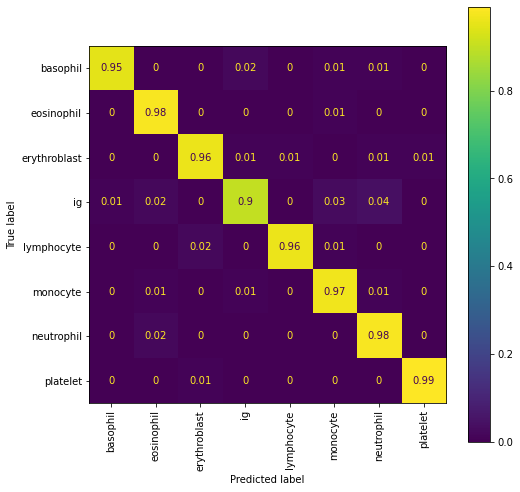

In [192]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
matrice = confusion_matrix(eval_class_name,eval_predict_class_name,normalize='true').round(2)
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(111) 
ConfusionMatrixDisplay(matrice).plot(ax=ax)
plt.xticks(range(8),lst_classes,rotation=90)
plt.yticks(range(8),lst_classes);

> IG sont confondus avec neutrophil,monocyte et eosinophil
>
> Confusion eosinophil/neutrophil

#### Transfer Learning avec modèle VGG16  modifié
* Freeze de toutes les couches
* Couches Dense 1024, 1024, 1024
* Dropout 
* Compilation avec Adam avec learning_rate de 10-4

In [189]:
base_model = VGG16(weights='imagenet', include_top=False)
#Freeze les couches => 
for layer in base_model.layers:
    layer.trainable = False    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1024,activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=8,activation='softmax')) #8 Classes

model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [190]:
#Entrainement
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 3796s 11s/step - loss: 1.0282 - accuracy: 0.6490 - val_loss: 0.4321 - val_accuracy: 0.8559
Epoch 2/16
342/342 [==============================] - 3636s 11s/step - loss: 0.4808 - accuracy: 0.8323 - val_loss: 0.3153 - val_accuracy: 0.8907
Epoch 3/16
342/342 [==============================] - 3769s 11s/step - loss: 0.3692 - accuracy: 0.8705 - val_loss: 0.2920 - val_accuracy: 0.9024
Epoch 4/16
342/342 [==============================] - 3632s 11s/step - loss: 0.3081 - accuracy: 0.8927 - val_loss: 0.2877 - val_accuracy: 0.9024
Epoch 5/16
342/342 [==============================] - 3555s 10s/step - loss: 0.2611 - accuracy: 0.9084 - val_loss: 0.2786 - val_accuracy: 0.8987
Epoch 6/16
342/342 [==============================] - 3628s 11s/step - loss: 0.2276 - accuracy: 0.9218 - val_loss: 0.2538 - val_accuracy: 0.9115
Epoch 7/16
342/342 [==============================] - 3539s 10s/step - loss: 0.2012 - accuracy: 0.9298 - val_loss: 0.2469 - val_ac

In [193]:
model.save("vgg16_2")

INFO:tensorflow:Assets written to: vgg16_2\assets


#### Prédictions sur données d'évaluation , 2ème modèle VGG16

In [191]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 898s 8s/step - loss: 0.2519 - accuracy: 0.9199


[0.25185298919677734, 0.9198595881462097]

In [194]:
#Prédictions
predict = model.predict(eval_generator)
eval_predict_class = predict.argmax(axis = 1)
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.95      0.91      0.93       222
  eosinophil       0.91      0.95      0.93       627
erythroblast       0.87      0.93      0.90       311
          ig       0.85      0.91      0.88       590
  lymphocyte       0.94      0.92      0.93       236
    monocyte       0.92      0.82      0.87       302
  neutrophil       0.97      0.90      0.93       682
    platelet       0.98      0.98      0.98       449

    accuracy                           0.92      3419
   macro avg       0.92      0.92      0.92      3419
weighted avg       0.92      0.92      0.92      3419



> Résultat inférieur (92% au lieu de 96%) au modèle VGG16 sans Dropout et couches Dense 1024/512/256
>
> Modèle non retenu